In [633]:
import requests
import nyc_geoclient
from nyc_geoclient import Geoclient
import numpy as np
import pandas as pd
import geopandas as gpd
import folium as fl
import mplleaflet as mpll
import seaborn as sns
import pylab as plt
from IPython.display import HTML
from datetime import datetime
% pylab inline
import urllib
import zipfile
import os


from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point

from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.model_selection import train_test_split

import sodapy
from sodapy import Socrata

Populating the interactive namespace from numpy and matplotlib


In [10]:
path = "/projects/18_predicting_igc/shared/data/"

# I registered this ID and key to the GeoCoder API for our project, so use it if you wish

app_ID = "ebc3a911"
app_key = "4bf9b57657e7fedb10b6998182f588e6"
g = Geoclient(app_ID, app_key)

## 1. Import and clean master inspections csv
This is Kelsey's latest version and includes census data plus PLUTO for each unique complaint ID


In [208]:
df = pd.read_csv("inspections_master_v5.csv")
columns = [col for col in df.columns]

In [209]:
df.drop(columns=['fire_violations','ECB_violation_number'],inplace=True)
df['insp_date']=pd.to_datetime(df['insp_date'])
df.head(2)

,Unnamed: 0,Unnamed: 0.1,priority_code,community_board,address,ZIP,borough,BIN,ID,complaint_category,...,Norm_Tot_S,Norm_Tot_A,Norm_Tot_B,Norm_Tot_M,Norm_Tot_P,Norm_Med_H,Norm_Tot_O,Norm_Tot_V,Norm_Tot_1,Norm_Tot_R
0,0,0,B,102,110 CHRISTOPHER STREET,10014.0,Manhattan,1010038,1272891,66,...,0.097589,0.042671,0.477421,0.202641,0.0,28.682185,0.82,0.18,0.25,3.04
1,1,2,C,110,2492 7 AVENUE,10030.0,Manhattan,1060459,1272972,94,...,0.201787,0.054574,0.090503,0.029715,0.0,8.422677,0.91,0.09,0.02,43.64


## 2. Add lat / lon for each BIN
Based on centroid of each building footprint

In [634]:
# downloading the data
site = 'https://data.cityofnewyork.us/api/geospatial/nqwf-w8eh?method=export&format=Shapefile'
urllib.urlretrieve(site, path + "building_footprints.zip")

('/projects/18_predicting_igc/shared/data/building_footprints.zip',
 <httplib.HTTPMessage instance at 0x7fd32d309758>)

In [635]:
# unzipping the downloaded data
zip_ref = zipfile.ZipFile(path + "building_footprints.zip", 'r')
zip_ref.extractall(path + "/bfp/")
zip_ref.close()

In [636]:
# building footprint that contains BIN number
bfp = gpd.GeoDataFrame.from_file(path + "/bfp/" + [file for file in os.listdir(path + "/bfp/")\
                                                   if "geo_export_" in file and ".shp" in file][0])

bfp.head()

,heightroof,bin,lststatype,shape_area,date_lstmo,time_lstmo,feat_code,cnstrct_yr,name,doitt_id,shape_len,groundelev,geometry
0,21.540000,4441987.0,Constructed,1089.812313,2017-12-19,00:00:00.000,2100.0,1993.0,,1283366.0,166.785929,70.0,POLYGON ((-73.81023637428498 40.72623326367574...
1,16.381832,4518072.0,Constructed,329.898503,2017-08-17,00:00:00.000,5110.0,1920.0,,964744.0,77.673856,6.0,POLYGON ((-73.86002815218995 40.57354222487876...
2,26.795523,4299860.0,Constructed,1234.856322,2017-08-22,00:00:00.000,2100.0,1940.0,,547717.0,146.929814,8.0,POLYGON ((-73.76711333552652 40.61130961765306...
3,11.358426,4516837.0,Constructed,275.411758,2017-08-17,00:00:00.000,5110.0,1930.0,,861127.0,68.476327,29.0,POLYGON ((-73.74704802666373 40.60410892416903...
4,26.632714,4301765.0,Constructed,1420.221189,2017-08-22,00:00:00.000,2100.0,1931.0,,288652.0,208.893121,6.0,POLYGON ((-73.77058283711517 40.59512166364137...


In [637]:
# truncating the building footprint dataset so that it only cantains the BIN numbers that appear in master dataset
bfp_w_c = bfp[bfp['bin'].isin(df['BIN'].unique())]
bfp_w_c.shape

(18313, 13)

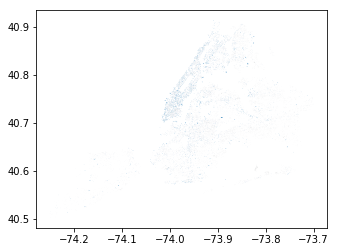

In [638]:
bfp_w_c.plot()

In [639]:
# each footprint is a polygon. for the convenience of collecting statistics,
# we abstract each footprint from a polygon to a point which is represented by its centroid point.
bfp_w_c['centroid'] = bfp_w_c['geometry'].centroid
bfp_w_c = bfp_w_c.reset_index()
bfp_w_c.head()

/nfshome/nj935/.conda/envs/remote_sensing/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,index,heightroof,bin,lststatype,shape_area,date_lstmo,time_lstmo,feat_code,cnstrct_yr,name,doitt_id,shape_len,groundelev,geometry,centroid
0,16,25.490348,4304631.0,Constructed,1560.247259,2017-08-22,00:00:00.000,2100.0,1960.0,,88483.0,166.259522,9.0,POLYGON ((-73.84326399116291 40.57801057539084...,POINT (-73.84335096773393 40.57806292518811)
1,49,25.899123,4530369.0,Constructed,1246.302843,2017-08-22,00:00:00.000,2100.0,2004.0,,1096274.0,152.459978,5.0,POLYGON ((-73.79994943969999 40.59308623918538...,POINT (-73.79999875351163 40.59315578743121)
2,59,29.184236,4306187.0,Constructed,1201.533270,2017-08-22,00:00:00.000,2100.0,1930.0,,747444.0,153.076211,10.0,POLYGON ((-73.84867080926294 40.57342838102142...,POINT (-73.8487468582436 40.57337473487058)
3,141,23.530000,4266771.0,Constructed,1237.373118,2017-08-22,00:00:00.000,2100.0,1960.0,,743660.0,153.137450,13.0,POLYGON ((-73.77833659957435 40.66846945412479...,POINT (-73.77823728723997 40.66844370773062)
4,228,15.280865,4312774.0,Constructed,971.340294,2017-08-22,00:00:00.000,2100.0,1935.0,,50778.0,141.633367,6.0,POLYGON ((-73.81629395809451 40.60827378560328...,POINT (-73.81639354609739 40.60827888946503)


In [640]:
# getting the lat and lon coordinates from the shapely geometry 
listarray1 = [] # list for storing longitude
for pp in bfp_w_c['centroid']:
    listarray1.append(pp.x)
    
listarray2 = [] # list for storing latitude
for pp in bfp_w_c['centroid']:
    listarray2.append(pp.y)

In [644]:
bfp_coord = list(zip(bfp_w_c['bin'], listarray2, listarray1))
bfp_coord = np.array(bfp_coord)
bfp_coord

array([[ 4.30463100e+06,  4.05780629e+01, -7.38433510e+01],
       [ 4.53036900e+06,  4.05931558e+01, -7.37999988e+01],
       [ 4.30618700e+06,  4.05733747e+01, -7.38487469e+01],
       ...,
       [ 1.08988000e+06,  4.07516641e+01, -7.39720748e+01],
       [ 1.81316000e+06,  4.08384391e+01, -7.39367392e+01],
       [ 1.05143700e+06,  4.07879872e+01, -7.39552326e+01]])

In [645]:
columns = ['BIN', 'lat', 'lon']
bfp_coord = pd.DataFrame(bfp_coord, columns = columns)
bfp_coord.head()

,BIN,lat,lon
0,4304631.0,40.578063,-73.843351
1,4530369.0,40.593156,-73.799999
2,4306187.0,40.573375,-73.848747
3,4266771.0,40.668444,-73.778237
4,4312774.0,40.608279,-73.816394


In [646]:
df = pd.merge(df, bfp_coord, left_on = 'BIN', right_on = 'BIN')

,Unnamed: 0,Unnamed: 0.1,priority_code,community_board,address,ZIP,borough,BIN,ID,complaint_category,...,years_since_alteration,building_age,"(pre-1900,)","(1900-1915,)","(1916-1937,)","(1938-1967,)","(1968-2007,)","(2008-2016,)",lat,lon
0,0,0,B,102,110 CHRISTOPHER STREET,10014.0,Manhattan,1010038,1272891,66,...,5.0,1915-1937,0,1,0,0,0,0,40.733106,-74.005039
1,1,2,C,110,2492 7 AVENUE,10030.0,Manhattan,1060459,1272972,94,...,31.0,1915-1937,0,1,0,0,0,0,40.821527,-73.939633
2,9,16,C,110,2492 7 AVENUE,10030.0,Manhattan,1060459,1273449,94,...,31.0,1915-1937,0,1,0,0,0,0,40.821527,-73.939633
3,173,305,C,110,2492 7 AVENUE,10030.0,Manhattan,1060459,1280823,94,...,31.0,1915-1937,0,1,0,0,0,0,40.821527,-73.939633
4,2,3,B,101,116 JOHN STREET,10038.0,Manhattan,1001126,1273017,66,...,7.0,1915-1937,0,1,0,0,0,0,40.707469,-74.005891


## 3. Query 311 complaints through Socrata

#### 3.1 Function to download complaint counts from Socrata API

In [ ]:
client = Socrata("data.cityofnewyork.us", "uLp3qFGblbiC7tI4pcHRU41fd")
nyc_dataset_identifier = 'fhrw-4uyv'

center = "40.729526, -73.993844"
center2 = df

In [840]:
def count_311_complaints(ID,complaint_type,radius=500,daysback=365):
    
    """Returns counts of selected 311 complaints within a given radius
    of the complaint ID in a given time window.
    """
    
    # create a SQL term for the date range
    end_date = df.insp_date[df.ID == ID].iloc[0]
    start_date = end_date - datetime.timedelta(days = daysback)    
    date_term = "created_date between '" + \
    str(start_date.isoformat()) + "' and '" + str(end_date.isoformat()) +"'"
    
    # create SQL term for the radius around each BIN (counts within this area)
    ll_df = df.loc[df.ID == ID,['lat','lon']] 
    latlon = str(ll_df.iloc[0,0]) + "," + str(ll_df.iloc[0,1])
    location_term = "within_circle(location,"+latlon + ", "+str(radius)+")"
    
    # print(date_term, complaint_type,location_term)
    
    results = client.get(nyc_dataset_identifier,
        select = "count(bbl)",             
        where= "complaint_type = '" + complaint_type + "' and "+ date_term +" and " + location_term)

    return(int(results[0]['count_bbl']))

print(count_311_complaints(ID = 2254138,complaint_type = 'Rodent'))


83


In [808]:
# sample IDs for test purposes

df_10_worst_ECB_vios = df.sort_values(by="ECB_violations",ascending=False).head(10)
sample_IDs = [x for x in df_10_worst_ECB_vios.ID]
sample_IDs

[1471413,
 2254138,
 2254136,
 2254141,
 2254135,
 4716982,
 2258107,
 1446915,
 1470688,
 1470685]

In [841]:
for i in sample_IDs:
    print(count_311_complaints(ID = i,complaint_type = 'Rodent'))
    

24
83
83
83
83
27
68
15
19
19


#### 3.2 Select complaint types to include from list of complaint types by agency

In [756]:
# get agency names

results = client.get(nyc_dataset_identifier,           
        limit = 5000)
results_df = pd.DataFrame.from_dict(results)
agency_names = results_df.agency.unique()
agency_names.tolist()

In [768]:
# identify unique complaint types by agency

complaint_cats = {}

for i in agency_names:
    term = "agency = '" + i + "'"
    results = client.get(nyc_dataset_identifier,           
    select = 'complaint_type',
    where = term,limit = 100)
    results_df = pd.DataFrame.from_dict(results)
    complaint_cats[i] = [results_df.complaint_type.unique()]

In [862]:
for key in complaint_cats.keys():
    print key + ":\n"
    print [value for value in complaint_cats[key]]

DSNY:

[array([u'Graffiti', u'Dirty Conditions', u'Sweeping/Inadequate',
       u'Sanitation Condition', u'Derelict Bicycle',
       u'Missed Collection (All Materials)', u'Other Enforcement',
       u'Litter Basket / Request', u'Overflowing Litter Baskets',
       u'Sweeping/Missed', u'Vacant Lot'], dtype=object)]
DPR:

[array([u'New Tree Request', u'Damaged Tree', u'Overgrown Tree/Branches',
       u'Maintenance or Facility', u'Violation of Park Rules',
       u'Dead/Dying Tree', u'Animal in a Park', u'DPR Internal',
       u'Root/Sewer/Sidewalk Condition', u'Illegal Tree Damage'],
      dtype=object)]
DOHMH:

[array([u'Rodent', u'Indoor Air Quality', u'Food Establishment',
       u'Food Poisoning', u'Harboring Bees/Wasps', u'Smoking',
       u'Standing Water', u'Poison Ivy', u'Day Care', u'Mosquitoes',
       u'Tanning', u'Illegal Animal Kept as Pet', u'Asbestos',
       u'Unsanitary Animal Pvt Property', u'Cooling Tower'], dtype=object)]
DEP:

[array([u'Water Conservation', u'Hazar

In [782]:
# choose categories
complaint_cats['NYPD']


[array([u'Noise - Commercial', u'Noise - Residential',
        u'Noise - Street/Sidewalk', u'Derelict Vehicle',
        u'Illegal Parking', u'Blocked Driveway', u'Noise - Vehicle',
        u'Non-Emergency Police Matter', u'Drinking'], dtype=object)]

In [785]:
cats_for_311_features = {
    'DSNY': ['Graffiti','Dirty Conditions','Sweeping/Inadequate','Sanitation Condition',
             'Missed Collection (All Materials)','Overflowing Litter Baskets',
            'Vacant Lot'],
    'DOB' : ['General Construction/Plumbing', 'Plumbing', 'Building/Use',
        'Special Projects Inspection Team (SPIT)', 'Electrical',
        'Boilers'],
    'HPD' : ['GENERAL', 'HEAT/HOT WATER', 'PAINT/PLASTER',
        'UNSANITARY CONDITION', 'PLUMBING', 'WATER LEAK', 'SAFETY',
        'ELECTRIC', 'ELEVATOR', 'FLOORING/STAIRS'],
    'DOHMH' : ['Rodent','Indoor Air Quality','Mosquitoes','Asbestos','Cooling Tower',
              'Standing Water'],
    'DOF' : ['SCRIE','Taxpayer Advocate Inquiry'],
    'DPR' : ['Root/Sewer/Sidewalk Condition'],
    'NYPD' : ['Derelict Vehicle','Non-Emergency Police Matter','Drinking']    
}

#### 2.3 Apply function to dataframe


In [861]:
for key in cats_for_311_features.keys():
    print key + ":\n"
    print [value for value in cats_for_311_features[key]]

DSNY:

['Graffiti', 'Dirty Conditions', 'Sweeping/Inadequate', 'Sanitation Condition', 'Missed Collection (All Materials)', 'Overflowing Litter Baskets', 'Vacant Lot']
DPR:

['Root/Sewer/Sidewalk Condition']
DOHMH:

['Rodent', 'Indoor Air Quality', 'Mosquitoes', 'Asbestos', 'Cooling Tower', 'Standing Water']
DOB:

['General Construction/Plumbing', 'Plumbing', 'Building/Use', 'Special Projects Inspection Team (SPIT)', 'Electrical', 'Boilers']
DOF:

['SCRIE', 'Taxpayer Advocate Inquiry']
NYPD:

['Derelict Vehicle', 'Non-Emergency Police Matter', 'Drinking']
HPD:

['GENERAL', 'HEAT/HOT WATER', 'PAINT/PLASTER', 'UNSANITARY CONDITION', 'PLUMBING', 'WATER LEAK', 'SAFETY', 'ELECTRIC', 'ELEVATOR', 'FLOORING/STAIRS']


In [ ]:
# ideal way to do it, but it's giving me a time-out error

for key in cats_for_311_features.keys():
    for value in cats_for_311_features[key]:
        field_name = "311: " + value
        df[value] = df_test.ID.apply(count_311_complaints,args = (value,365))

In [871]:
cats_for_311_features.keys()

['DSNY', 'DPR', 'DOHMH', 'DOB', 'DOF', 'NYPD', 'HPD']

In [ ]:
value = cats_for_311_features['HPD'][0]
df[value] = df.ID.apply(count_311_complaints,args = (value,365))
df

In [916]:
value = cats_for_311_features['HPD']
df_test[value] = df_test.ID.apply(count_311_complaints,args = (value,365))
df_test

,Unnamed: 0,Unnamed: 0.1,priority_code,community_board,address,ZIP,borough,BIN,ID,complaint_category,...,GENERAL,HEAT/HOT WATER,PAINT/PLASTER,UNSANITARY CONDITION,PLUMBING,WATER LEAK,SAFETY,ELECTRIC,ELEVATOR,FLOORING/STAIRS
0,0,0,B,102,110 CHRISTOPHER STREET,10014.0,Manhattan,1010038,1272891,66,...,0,0,0,0,1,0,0,0,0,0
1,1,2,C,110,2492 7 AVENUE,10030.0,Manhattan,1060459,1272972,94,...,0,0,0,0,6,0,0,0,0,0
2,9,16,C,110,2492 7 AVENUE,10030.0,Manhattan,1060459,1273449,94,...,0,0,0,0,51,0,0,6,0,0
3,173,305,C,110,2492 7 AVENUE,10030.0,Manhattan,1060459,1280823,94,...,0,0,0,0,202,0,0,41,0,0
4,2,3,B,101,116 JOHN STREET,10038.0,Manhattan,1001126,1273017,66,...,0,0,0,0,8,0,0,0,0,0
5,759,1295,B,101,116 JOHN STREET,10038.0,Manhattan,1001126,1309525,66,...,0,0,0,0,41,0,0,5,0,0
6,3,5,C,110,2445 FREDERICK DOUGLAS BOULEVARD,10027.0,Manhattan,1059412,1273032,94,...,0,0,0,0,115,0,0,37,0,0
7,130,220,C,110,2445 8 AVENUE,10027.0,Manhattan,1059412,1280293,94,...,0,0,0,0,134,0,0,38,0,0
8,4,6,A,103,420 EAST 10 STREET,10009.0,Manhattan,1004547,1273060,65,...,0,0,0,0,5,0,0,0,0,0
9,5,8,B,109,409 EDGECOMB AVENUE,10031.0,Manhattan,1061186,1273225,65,...,0,0,0,0,12,0,0,3,0,0


In [850]:
df_test.ID.apply(count_311_complaints,args = ('Rodent',365))

0       0
1       1
2       9
3      36
4       7
5      54
6      15
7      28
8       0
9       6
10    184
11    369
12      0
13    118
14    118
15    120
16    119
17    119
18    120
19    122
Name: ID, dtype: int64

In [816]:
df.apply?

### 3.1 Demo of mapping a given query

In [76]:
# make lat and lon into numbers
results_df.latitude = pd.to_numeric(results_df.latitude)
results_df.longitude = pd.to_numeric(results_df.longitude)
#results_df.dtypes

In [77]:
s = gpd.GeoSeries([Point(x,y) for x, y in zip(results_df['longitude'], results_df['latitude'])])
geo_df = gpd.GeoDataFrame(results_df,geometry = s)
geo_df.crs = {'init': 'epsg:4326'}

In [78]:
geo_df.head(2)

,address_type,agency,agency_name,bbl,borough,city,closed_date,community_board,complaint_type,created_date,...,park_borough,park_facility_name,resolution_action_updated_date,resolution_description,status,street_name,unique_key,x_coordinate_state_plane,y_coordinate_state_plane,geometry
0,ADDRESS,DOB,Department of Buildings,1000800004,MANHATTAN,NEW YORK,2017-02-03T12:05:39.000,01 MANHATTAN,Special Projects Inspection Team (SPIT),2017-02-03T12:05:39.000,...,MANHATTAN,Unspecified,2017-02-03T00:00:00.000,The Department of Buildings investigated this ...,Closed,CHURCH STREET,35410275,981338,198478,POINT (-74.01050379268059 40.7114525313996)
1,ADDRESS,DOB,Department of Buildings,1008220067,MANHATTAN,NEW YORK,2017-04-27T00:00:00.000,05 MANHATTAN,Special Projects Inspection Team (SPIT),2017-02-08T19:31:09.000,...,MANHATTAN,Unspecified,2017-04-27T00:00:00.000,The Department of Buildings attempted to inves...,Closed,WEST 21 STREET,35447461,986444,209212,POINT (-73.99208258522924 40.74091495786753)


In [571]:
fl?

In [569]:
fig, ax = plt.subplots(1, figsize=(10,10))
geo_df.plot(c='r',ax=ax)
mpll.display(fig=fig, crs = geo_df.crs, tiles='cartodb_positron')

## 4. Function to add violation counts
Should be able to use one function for multiple datasets

#### 4.1 Load and clean violation datasets to count from
Get counts from any dataset which has BIN and VIO_DATE

In [261]:
fire_violations = pd.read_csv(path + 'Additional Risk Factors/Bureau_of_Fire_Prevention_-_Active_Violation_Orders.csv')
wwp = pd.read_csv(path + 'work_without_permit_violation_issued_by_plumbing_unit_since_010110.csv')
laa = pd.read_csv(path + 'laa_filings_2010_2017.csv')
complaints_deduped = pd.read_csv(path + 'inspections_master_v1_1.csv')

In [211]:
# Make violation date a datetime object

fire_violations.rename(columns={'VIO_DATE':'DATE'},inplace=True)

fire_violations.DATE=pd.to_datetime(fire_violations.DATE)

In [262]:
### Work Without Permit (WWP) violations
wwp.rename(columns={'Vio Issued Date':'DATE',
                   'BIN-Occurrence':'BIN',
                   'Block-Occurrence':'Block'},inplace=True)

#wwp.drop(axis = 1, columns = ['License# Rep','House# Resp'],inplace=True)
wwp.dropna(axis=0,inplace=True)

wwp.BIN.astype(int,copy=True)
wwp['DATE']=pd.to_datetime(wwp['DATE'])


In [213]:
# 1L referrals dataset prep

referrals_1L = pd.read_csv(path + "gas_high_risk_1l_utility_referral_since_aug_2016.csv")
referrals_1L.rename(columns={'COMPLAINT_DATE':'DATE',
                   'BIN Number':'BIN'},inplace=True)
referrals_1L['DATE']=pd.to_datetime(referrals_1L['DATE'])
referrals_1L.head(1)

,BIN,Complaint Number,Complaint Category,Complaint Category Description,Priority Code,Borough Digit,Borough Name,P_HOUSE_NUMBER,P_STREET_NAME,P_ZIP,...,D_MONTH,D_YEAR,INSPECTION_DATE,Inspector ID,Disposition Code,Complaint Disposition Description,cnxarraycolumn,Inspector Comments,C_NOTIFICATION_TEXT,ECB Violation Number
0,1000040,1467087,1L,GAS UTILITY REFERRAL,D,1,Manhattan,15,STONE STREET,10004,...,1,2018,1/22/2018 0:00,2744,I2,NO VIOLATION WARRANTED FOR COMPLAINT AT TIME O...,0,OPEN PLUMBING PERMIT #122639886-01-PL ON PROPE...,NaN,NaN


In [214]:
# LAA filings dataset prep
laa.head(1)
laa.rename(columns={'LAA Submission Date':'DATE',
                   'BIN Number':'BIN'},inplace=True)
laa['DATE']=pd.to_datetime(referrals_1L['DATE'])

In [215]:
# Complants de-duped
complaints_deduped.rename(columns={'date_received':'DATE'},inplace=True)
complaints_deduped['DATE']=pd.to_datetime(complaints_deduped['DATE'])

In [122]:
# ECB vios - maybe add later

# ECBVios = pd.read_csv(path + "OATH_Hearings_Division_Case_Status(1).csv")
# ECBVios.rename(columns={'Violation Date':'VIO_DATE'},inplace=True)

#### 4.2 Function to count violations at BIN level

In [825]:
def count_violations_BIN(ID, daysback, viodataset):
    
    ''' Requires a dataset to be passed where each row is a
    unique code violation including columns 'BIN' and 'VIO_DATE'
    
    Returns number of violations within a 'daysback' window from
    the first violation date at that address'''
    
    end_date = df.insp_date[df.ID == ID].iloc[0]
    start_date = end_date - datetime.timedelta(days = daysback)
    BIN = df.BIN[df.ID == ID].iloc[0]

    return viodataset[(viodataset.BIN == BIN) & (viodataset.DATE > start_date) &
                           (viodataset.DATE < end_date)].shape[0]

count_violations_by_ID(1272891,1820,fire_violations)

0

#### 3.3 Run the function for each dataset

In [254]:
# run function for fire violations

df['fire_violations'] = df.ID.apply(count_violations_BIN,args=(1825,fire_violations))

In [218]:
# run function for WWP violations

df['wwp_vios'] = df.ID.apply(count_violations_BIN,args=(1825,wwp))

In [219]:
# for 1L complaints

df['complaints_1L'] = df.ID.apply(count_violations_BIN,args=(1825,referrals_1L))

In [220]:
# for LAA filings

df['laa_filings'] = df.ID.apply(count_violations_BIN,args=(1825,laa))

In [221]:
# for complaints dataset de-duped
# --> create features for number of cat A/B/C/D complaints at BIN

df['plumbing_complaints_cat_A'] = df.ID[df.priority_code=="A"].apply(count_violations_by_ID,args=(1825,complaints_deduped))
df['plumbing_complaints_cat_B'] = df.ID[df.priority_code=="B"].apply(count_violations_by_ID,args=(1825,complaints_deduped))
df['plumbing_complaints_cat_C'] = df.ID[df.priority_code=="C"].apply(count_violations_by_ID,args=(1825,complaints_deduped))
df['plumbing_complaints_cat_D'] = df.ID[df.priority_code=="D"].apply(count_violations_by_ID,args=(1825,complaints_deduped))

for feature in ['plumbing_complaints_cat_A','plumbing_complaints_cat_B','plumbing_complaints_cat_C','plumbing_complaints_cat_D']:
    df[feature].fillna(0,inplace=True)

#### 4.3 Function to count violations at Block level

In [223]:
def count_violations_block(ID, daysback, viodataset):
    
    ''' Requires a dataset to be passed where each row is a
    unique code violation including columns 'BIN' and 'VIO_DATE'
    
    Returns number of violations within a 'daysback' window from
    the first violation date at that address'''
    
    end_date = df.insp_date[df.ID == ID].iloc[0]
    start_date = end_date - datetime.timedelta(days = daysback)
    Block = df.Block[df.ID == ID].iloc[0]

    return viodataset[(viodataset.Block == Block) &
                           (viodataset.DATE < end_date)].shape[0]

In [265]:
df['wwp_vios_block'] = df.ID.apply(count_violations_block,args=(1825,wwp))
df.wwp_vios_block.describe()

count    25716.000000
mean         0.033014
std          0.197689
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: wwp_vios_block, dtype: float64

In [ ]:
#copy the master dataframe to run the counts_by_block function on it

df_for_counts = df.copy()
df_for_counts.rename(columns={'date_received':'DATE'},inplace=True)
df_for_counts.DATE = pd.to_datetime(df_for_counts.DATE)

In [ ]:
# Run for plumbing complaints of categories A/B/C/D

df['plumbing_complaints_cat_A_block'] = df.ID[df.priority_code=="A"].apply(count_violations_block,args=(1825,df_for_counts))
df['plumbing_complaints_cat_B_block'] = df.ID[df.priority_code=="B"].apply(count_violations_block,args=(1825,df_for_counts))
df['plumbing_complaints_cat_C_block'] = df.ID[df.priority_code=="C"].apply(count_violations_block,args=(1825,df_for_counts))
df['plumbing_complaints_cat_D_block'] = df.ID[df.priority_code=="D"].apply(count_violations_block,args=(1825,df_for_counts))

for feature in ['plumbing_complaints_cat_A_block','plumbing_complaints_cat_B_block',
                'plumbing_complaints_cat_C_block','plumbing_complaints_cat_D_block']:
    df[feature].fillna(0,inplace=True)



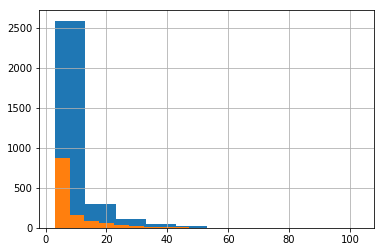

In [239]:
# compare the BIN counts with the block counts. As expected, there are
# more complaints for block than BIN.

df.plumbing_complaints_cat_A_block[df.plumbing_complaints_cat_A_block>2].hist()
df.plumbing_complaints_cat_A[df.plumbing_complaints_cat_A>2].hist()

## 5. Add PLUTO-derived features
 - Building age
 - Years since major alteration

#### 5.1 Building age range

In [ ]:
df.YearBuilt.replace((0,np.nan),inplace=True)

In [319]:
def building_age_range(year):
    if year < 1900:
        return ("pre-1900")
    elif year < 1915:
        return ("1900-1915")
    elif year < 1937:
        return ('1915-1937')
    elif year < 1968:
        return ('1937-1968')
    elif year < 2007:
        return ('1968-2007')
    else:
        return ('2008-2016')

In [320]:
df['building_age'] = df.YearBuilt.apply(building_age_range)

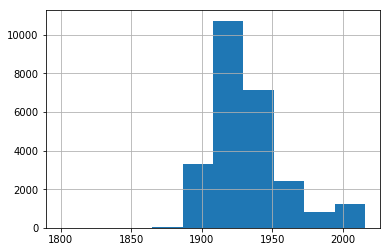

In [324]:
df.YearBuilt.hist()

In [321]:
df.building_age.value_counts(normalize=True)

1915-1937    0.489695
1900-1915    0.216830
1937-1968    0.172422
1968-2007    0.074662
pre-1900     0.028193
2008-2016    0.018199
Name: building_age, dtype: float64

In [325]:
# Add dummies for building age

a=pd.get_dummies(df.building_age)
a.columns=[['pre-1900','1900-1915', '1916-1937', '1938-1967', '1968-2007', '2008-2016']]
df = pd.concat([df,a],axis=1)

#### 5.2 Years since major alteration

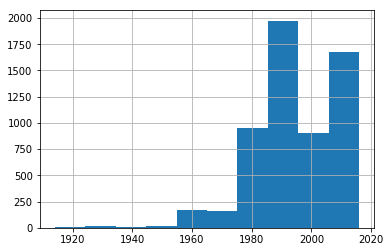

In [276]:
df.YearAlter1.replace(0,np.nan, inplace=True)
df.YearAlter1.hist()

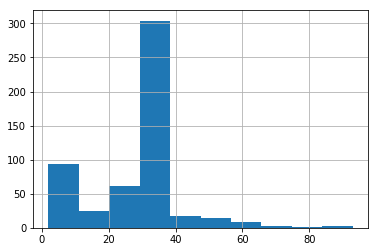

In [568]:
df['years_since_alteration'] = datetime.now().year - df.YearAlter1

df.years_since_alteration[:1000].hist()

In [374]:
## Add function to fill NaNs based on average for the building class
# --> Hongkai, Ozgur?

#### 5.3 Add indicator of rent stabilized units present
Source: https://github.com/talos/nyc-stabilization-unit-counts

In [623]:
rs_df = pd.read_csv('data/rent_stab.csv')
rs_df

,borough,ucbbl,2007uc,2007est,2007dhcr,2007abat,2008uc,2008est,2008dhcr,2008abat,...,address,ownername,numbldgs,numfloors,unitsres,unitstotal,yearbuilt,condono,lon,lat
0,MN,1000160180,293.0,N,NaN,NaN,293.0,N,NaN,NaN,...,20 RIVER TERRACE,NaN,1.0,27.0,293.0,294.0,2002.0,0.0,-74.0161,40.7166
1,MN,1000160185,253.0,N,NaN,NaN,253.0,N,NaN,NaN,...,211 NORTH END AVENUE,NaN,1.0,24.0,253.0,256.0,2004.0,0.0,-74.0155,40.7163
2,NaN,1000160235,NaN,N,NaN,NaN,NaN,N,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MN,1000170029,97.0,N,NaN,NaN,60.0,N,NaN,NaN,...,90 WASHINGTON STREET,"EKATZ FAMILY, LLC",1.0,27.0,397.0,399.0,1969.0,0.0,-74.0148,40.7081
4,MN,1000250019,NaN,N,NaN,NaN,NaN,N,NaN,NaN,...,25 BROAD STREET,25 BROAD STREET L/CAL,1.0,21.0,308.0,311.0,1900.0,0.0,-74.0108,40.7059
5,MN,1000277502,NaN,N,NaN,NaN,NaN,N,NaN,NaN,...,20 EXCHANGE PLACE,TWENTY EXCHANGE PLACE,1.0,57.0,350.0,352.0,1929.0,1991.0,-74.0096,40.7055
6,MN,1000297501,4.0,N,NaN,NaN,2.0,N,NaN,NaN,...,48 BEAVER STREET,NaN,3.0,8.0,39.0,42.0,1920.0,1002.0,-74.0104,40.7050
7,MN,1000330011,NaN,N,NaN,NaN,NaN,N,NaN,NaN,...,95 WALL STREET,NINETY FIVE WALL STRE,1.0,22.0,507.0,510.0,1969.0,0.0,-74.0076,40.7047
8,MN,1000397501,5.0,N,NaN,NaN,5.0,N,NaN,NaN,...,164 PEARL STREET,THE SEAPORT SO CONDO,1.0,12.0,121.0,122.0,1956.0,122.0,-74.0072,40.7058
9,MN,1000420001,4.0,N,NaN,NaN,341.0,N,NaN,NaN,...,100 MAIDEN LANE,MAIDEN LANE PROPERTI,1.0,24.0,340.0,346.0,1930.0,0.0,-74.0072,40.7067


## 6. Review the set of features for machine learning
How many NaNs do we have? How many unique values?

In [921]:
feature_stats = pd.DataFrame({"NaNs":df.isnull().sum(),"unique":df.nunique()})
feature_stats['percent Nans'] = feature_stats.NaNs / len(df) * 100
feature_stats['percent unique'] = feature_stats.unique / len(df) * 100
feature_stats.head(20)

,NaNs,unique,percent Nans,percent unique
Unnamed: 0,0,25716,0.000000,100.000000
Unnamed: 0.1,0,25716,0.000000,100.000000
priority_code,0,4,0.000000,0.015555
community_board,0,65,0.000000,0.252761
address,1,19414,0.003889,75.493856
ZIP,17,185,0.066107,0.719396
borough,0,5,0.000000,0.019443
BIN,0,18630,0.000000,72.445170
ID,0,25716,0.000000,100.000000
complaint_category,0,4,0.000000,0.015555
